In [79]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm.auto import tqdm
import glob
import os
import sys
from copy import deepcopy

# pip3 install --user PyMuPDF
import fitz

In [38]:
%%bash
# https://www.google.com/covid19/mobility/
mkdir -p pdfs/
cd pdfs/

states="Alabama Alaska Arizona Arkansas California Colorado Connecticut Delaware Florida Georgia Hawaii Idaho Illinois Indiana Iowa Kansas Kentucky Louisiana Maine Maryland Massachusetts Michigan Minnesota Mississippi Missouri Montana Nebraska Nevada New_Hampshire New_Jersey New_Mexico New_York North_Carolina North_Dakota Ohio Oklahoma Oregon Pennsylvania Rhode_Island South_Carolina South_Dakota Tennessee Texas Utah Vermont Virginia Washington West_Virginia Wisconsin Wyoming"
date="2020-03-29"
for state in $states ; do
    curl -s -O https://www.gstatic.com/covid19/mobility/${date}_US_${state}_Mobility_Report_en.pdf
done

# rename the full US pdf slightly to conform to similar naming convention as the individual states
curl -s -o ${date}_US_US_Mobility_Report_en.pdf https://www.gstatic.com/covid19/mobility/${date}_US_Mobility_Report_en.pdf
    
# # non us countries conform to current naming pattern
countries="GB IT DE ES FR"

for country in $countries ; do
    curl -s -o ${date}_${country}_${country}_Mobility_Report_en.pdf https://www.gstatic.com/covid19/mobility/${date}_${country}_Mobility_Report_en.pdf
done

In [3]:
def parse_stream(stream):
    data_raw = []
    data_transformed = []
    rotparams = None
    npatches = 0
    for line in stream.splitlines():
        if line.endswith(" cm"):
            # page 146 of https://www.adobe.com/content/dam/acom/en/devnet/pdf/pdfs/pdf_reference_archives/PDFReference.pdf
            rotparams = list(map(float,line.split()[:-1]))
        elif line.endswith(" l"):
            x,y = list(map(float,line.split()[:2]))
            a,b,c,d,e,f = rotparams
            xp = a*x+c*y+e
            yp = b*x+d*y+f
            data_transformed.append([xp,yp])
            data_raw.append([x,y])
        elif line.endswith(" m"):
            npatches += 1
        else:
            pass
    data_raw = np.array(data_raw)
    basex, basey = data_raw[-1]
    good = False
    if basex == 0.:
        data_raw[:,1] = basey - data_raw[:,1]
        data_raw[:,1] *= 100/60.
        data_raw = data_raw[data_raw[:,1]!=0.]
        if npatches == 1: good = True
    return dict(data=np.array(data_raw), npatches=npatches, good=good)

In [155]:
def parse_page(doc, ipage, verbose=False):
    categories = [
        "Retail & recreation",
        "Grocery & pharmacy",
        "Parks",
        "Transit stations",
        "Workplace",
        "Residential",
    ]

    counties = []
    curr_county = None
    curr_category = None
    data = defaultdict(lambda: defaultdict(list))
    pagetext = doc.getPageText(ipage)
    lines = pagetext.splitlines()
    
    tickdates = list(filter(lambda x:len(x.split())==3, set(lines[-10:])))
    for line in lines:
        # don't need these lines at all
        if ("* Not enough data") in line: continue
        if ("needs a significant volume of data") in line: continue

        # if we encountered a category, add to dict, otherwise
        # push all seen lines into the existing dict entry
        if any(line.startswith(c) for c in categories):
            curr_category = line
        elif curr_category:
            data[curr_county][curr_category].append(line)

        # If it doesn't match anything, then it's a county name
        if (all(c not in line for c in categories)
            and ("compared to baseline" not in line)
            and ("Not enough data" not in line)
           ):
            # saw both counties already
            if len(data.keys()) == 2: break
            counties.append(line)
            curr_county = line
            
    newdata = {}
    for county in data:
        newdata[county] = {}
        for category in data[county]:
            # if the category text ends with a space, then there was a star/asterisk there
            # indicating lack of data. we skip these.
            if category.endswith(" "): continue
            temp = [x for x in data[county][category] if "compared to baseline" in x]
            if not temp: continue
            percent = int(temp[0].split()[0].replace("%",""))
            newdata[county][category.strip()] = percent
    data = newdata

    tomatch = []
    for county in counties:
        for category in categories:
            if category in data[county]:
                tomatch.append([county,category,data[county][category]])
    if verbose:
        print(len(tomatch))
        print(data)
    
    goodplots = []
    xrefs = sorted(doc.getPageXObjectList(ipage), key=lambda x:int(x[1].replace("X","")))
    for i,xref in enumerate(xrefs):
        stream = doc.xrefStream(xref[0]).decode()
        info = parse_stream(stream)
        if not info["good"]: continue
        goodplots.append(info)
    if verbose:
        print(len(goodplots))
    
    ret = []
    
    if len(tomatch) != len(goodplots):
        return ret
    
    
    for m,g in zip(tomatch,goodplots):
        xs = g["data"][:,0]
        ys = g["data"][:,1]
        maxys = ys[np.where(xs==xs.max())[0]]
        maxy = maxys[np.argmax(np.abs(maxys))]
        
        
        # parsed the tick date labels as text. find the min/max (first/last)
        # and make evenly spaced dates, one per day, to assign to x values between
        # 0 and 200 (the width of the plots).
        ts = list(map(lambda x: pd.Timestamp(x.split(None,1)[-1] + ", 2020"), tickdates))
        low, high = min(ts), max(ts)
        dr = list(map(lambda x:str(x).split()[0], pd.date_range(low, high, freq="D")))
        lutpairs = list(zip(np.linspace(0,200,len(dr)),dr))

        dates = []
        values = []
        asort = xs.argsort()
        xs = xs[asort]
        ys = ys[asort]
        for x,y in zip(xs,ys):
            date = min(lutpairs, key=lambda v:abs(v[0]-x))[1]
            dates.append(date)
            values.append(round(y,3))

        ret.append(dict(
            county=m[0],category=m[1],change=m[2],
            values=values,
            dates=dates,
            changecalc=maxy,
        ))
    return ret


In [219]:
def parse_front_pages(doc, verbose=False):
    categories = [
        "Retail & recreation",
        "Grocery & pharmacy",
        "Parks",
        "Transit stations",
        "Workplaces",
        "Residential",
    ]
    
    page1text = doc.getPageText(0)
    page2text = doc.getPageText(1)
    
    curr_category = None
    data = defaultdict(list)
    
    lines = page1text.splitlines() + page2text.splitlines()
    tickdates = list(filter(lambda x:len(x.split())==3, set(lines)))
    tickdates = list(
        filter(
            lambda x: (len(x.split()[0]) == 3) & (len(x.split()[1])==3) , set(tickdates)
        )
    )
        
    for line in lines:
        # don't need these lines at all
        if ("* Not enough data") in line: continue
        if ("needs a significant volume of data") in line: continue

        # if we encountered a category, add to dict, otherwise
        # push all seen lines into the existing dict entry
        if any(line.startswith(c) for c in categories):
            curr_category = line
        elif curr_category:
            data[curr_category].append(line)

#         # If it doesn't match anything, then it's a county name
#         if (all(c not in line for c in categories)
#             and ("compared to baseline" not in line)
#             and ("Not enough data" not in line)
#            ):
#             # saw both counties already
#             if len(data.keys()) == 2: break
#             counties.append(line)
#             curr_county = line
            
    for k in data.keys():
        data[k] = [data[k][0] + " " + data[k][1]]
        
    newdata = {}
    for category in data:
        # if the category text ends with a space, then there was a star/asterisk there
        # indicating lack of data. we skip these.
        if category.endswith(" "): continue
        temp = [x for x in data[category] if "compared to baseline" in x]
        if not temp: continue
        percent = int(temp[0].split()[0].replace("%",""))
        newdata[category.strip()] = percent
    data = newdata
    
    tomatch = []
    for category in categories:
        if category in data:
            tomatch.append([category,data[category]])
    if verbose:
        print(len(tomatch))
        print(data)
        
    goodplots = []
    xrefs = doc.getPageXObjectList(0) + doc.getPageXObjectList(1)
    xrefs = sorted(xrefs, key=lambda x:int(x[1].replace("X","")))
    for i,xref in enumerate(xrefs):
        stream = doc.xrefStream(xref[0]).decode()
        info = parse_stream(stream)
        if not info["good"]: continue
        goodplots.append(info)
    if verbose:
        print(len(goodplots))
#         print(goodplots)

    ret = []
    
    if len(tomatch) != len(goodplots):
        return ret
    
    for m,g in zip(tomatch,goodplots):
        if m[0] == "Workplaces":
            m[0] = "Workplace"
        
        xs = g["data"][:,0]
        ys = g["data"][:,1]
        maxys = ys[np.where(xs==xs.max())[0]]
        maxy = maxys[np.argmax(np.abs(maxys))]
        
        fudge_factor = 0.801 # Plots on the first pages are a slightly different height. Makes reported by google and calculated from plot line up
        
#         print(maxys)
#         print(maxy)

#         print(xs)
#         print(ys)

        # parsed the tick date labels as text. find the min/max (first/last)
        # and make evenly spaced dates, one per day, to assign to x values between
        # 0 and 200 (the width of the plots).
        ts = list(map(lambda x: pd.Timestamp(x.split(None,1)[-1] + ", 2020"), tickdates))
        low, high = min(ts), max(ts)
        dr = list(map(lambda x:str(x).split()[0], pd.date_range(low, high, freq="D")))
        lutpairs = list(zip(np.linspace(0,200,len(dr)),dr))
        
#         print(lutpairs)

        dates = []
        values = []
        asort = xs.argsort()
        xs = xs[asort]
        ys = ys[asort]
        for x,y in zip(xs,ys):
            date = min(lutpairs, key=lambda v:abs(v[0]-x))[1]
            dates.append(date)
            values.append(round(y * fudge_factor,3))

        ret.append(dict(
            category=m[0],change=m[1],
            values=values,
            dates=dates,
            changecalc=maxy * fudge_factor,
        ))
    return ret

doc = fitz.Document(f"pdfs/2020-03-29_GB_GB_Mobility_Report_en.pdf")

# parse_front_pages(doc)

In [220]:
!mkdir -p data/

def parse_state(state):
    doc = fitz.Document(f"pdfs/2020-03-29_US_{state}_Mobility_Report_en.pdf")
    data = []
    for entry in parse_front_pages(doc):
        entry["state"]=state
        entry["page"]=1
        entry["county"]="Overall"
        data.append(entry)
    for i in range(2,doc.pageCount-1):
        for entry in parse_page(doc, i):
            entry["state"] = state
            entry["page"] = i
            data.append(entry)
    outname = f"data/{state}.json.gz"
    df = pd.DataFrame(data)
    ncounties = df['county'].nunique()
    print(f"Parsed {len(df)} plots for {ncounties} counties in {state}")
    df = df[["state","county","category","change","changecalc","dates", "values","page"]]
    return df

def parse_country(country):
    doc = fitz.Document(f"pdfs/2020-03-29_{country}_{country}_Mobility_Report_en.pdf")
    data = []
    for entry in parse_front_pages(doc):
        entry["state"]=country
        entry["page"]=1
        entry["county"]="Overall"
        data.append(entry)
    for i in range(2,doc.pageCount-1):
        for entry in parse_page(doc, i):
            entry["state"] = country
            entry["page"] = i
            data.append(entry)
    outname = f"data/{country}.json.gz"
    df = pd.DataFrame(data)
    ncounties = df['county'].nunique()
    print(f"Parsed {len(df)} plots for {ncounties} counties in {country}")
    df = df[["state","county","category","change","changecalc","dates", "values","page"]]
    return df


In [221]:
# parse_state("New_York")
parse_country("GB")

Parsed 579 plots for 111 counties in GB


,state,county,category,change,changecalc,dates,values,page
0,GB,Overall,Retail & recreation,-85,-84.897280,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-6.652, 9.798, 6.822, 5.717, 4.716, 4.747, -3...",1
1,GB,Overall,Grocery & pharmacy,-46,-45.730850,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-6.477, 1.259, -1.024, -1.843, -1.877, -0.706...",1
2,GB,Overall,Parks,-52,-52.444930,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-28.08, 24.232, 19.702, 7.842, 4.138, 10.031,...",1
3,GB,Overall,Transit stations,-75,-74.810387,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-6.883, -1.573, -2.654, -3.769, -5.183, -2.52...",1
4,GB,Overall,Workplace,-55,-55.395666,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-2.804, -14.378, -13.683, -13.63, -14.302, -1...",1
...,...,...,...,...,...,...,...,...
574,GB,Worcestershire,Grocery & pharmacy,-47,-49.411545,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-6.135, 2.18, -0.819, 1.394, 0.17, -1.228, -0...",75
575,GB,Worcestershire,Parks,-44,-45.667267,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-34.345, 38.154, 8.102, 1.698, 1.806, 8.375, ...",75
576,GB,Worcestershire,Transit stations,-71,-74.372267,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[4.549, 13.619, 3.763, 5.599, 2.914, 12.812, 1...",75
577,GB,Worcestershire,Workplace,-55,-56.977068,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-5.243, -20.48, -17.849, -17.217, -17.761, -1...",75


In [222]:
# US will be included in the dataframe as a "state", and the states are "counties"
parse_country("DE").head()

Parsed 102 plots for 17 counties in DE


,state,county,category,change,changecalc,dates,values,page
0,DE,Overall,Retail & recreation,-77,-77.480050,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[6.718, 1.705, 2.039, 3.377, 2.48, 1.787, -0.6...",1
1,DE,Overall,Grocery & pharmacy,-51,-50.842904,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[9.959, 1.555, 1.804, 0.475, -1.158, 1.629, -1...",1
2,DE,Overall,Parks,-49,-49.339959,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[9.449, 7.5, 10.183, 5.521, 13.57, 14.539, 26....",1
3,DE,Overall,Transit stations,-68,-68.183379,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[6.018, 1.003, 0.88, -1.022, 3.328, -1.229, 8....",1
4,DE,Overall,Workplace,-39,-38.894270,"[2020-02-16, 2020-02-17, 2020-02-18, 2020-02-1...","[-0.889, -1.616, -0.906, -1.204, -3.895, -7.9,...",1


In [223]:
import glob

places = [x.split("_Mobility",1)[0].split("_",2)[2] for x in glob.glob("pdfs/*.pdf")]
countires = [s for s in places if len(s)==2]
countries_no_US = deepcopy(countires)
countries_no_US.remove("US")
states = [s for s in places if len(s) != 2]
print(countires)
print(states)

def parse_list_of_states(states, data_file='data'):
    dfs = []
    for state in states:
        dfs.append(parse_state(state))
    df = pd.concat(dfs).reset_index(drop=True)
    data = []
    for i,row in tqdm(df.iterrows()):
        # do a little clean up and unstack the dates/values as separate rows
        dorig = dict()
        dorig["state"] = row["state"].replace("_"," ")
        dorig["county"] = row["county"]
        dorig["category"] = row["category"].replace(" & ","/").replace(" ","").lower()
        dorig["page"] = row["page"]
        dorig["change"] = row["change"]
        dorig["changecalc"] = row["changecalc"]
        for x,y in zip(row["dates"],row["values"]):
            d = dorig.copy()
            d["date"] = x
            d["value"] = y
            data.append(d)
    df = pd.DataFrame(data)
    df.to_json(f"data/{data_file}.json.gz", orient="records", indent=2)
    
def parse_list_of_countires(countries, data_file='data'):
    dfs = []
    for country in countries:
        dfs.append(parse_country(country))
    df = pd.concat(dfs).reset_index(drop=True)
    data = []
    for i,row in tqdm(df.iterrows()):
        # do a little clean up and unstack the dates/values as separate rows
        dorig = dict()
        dorig["state"] = row["state"].replace("_"," ")
        dorig["county"] = row["county"]
        dorig["category"] = row["category"].replace(" & ","/").replace(" ","").lower()
        dorig["page"] = row["page"]
        dorig["change"] = row["change"]
        dorig["changecalc"] = row["changecalc"]
        for x,y in zip(row["dates"],row["values"]):
            d = dorig.copy()
            d["date"] = x
            d["value"] = y
            data.append(d)
    df = pd.DataFrame(data)
    df.to_json(f"data/{data_file}.json.gz", orient="records", indent=2)
    
parse_list_of_states(states, 'US_states')
parse_list_of_countires(countires, 'Countires')
parse_list_of_countires(countries_no_US, 'Countires_No_US')

['GB', 'ES', 'FR', 'IT', 'DE', 'US']
['Maryland', 'Iowa', 'Delaware', 'South_Carolina', 'Texas', 'South_Dakota', 'Illinois', 'North_Dakota', 'Oregon', 'Indiana', 'Missouri', 'Kentucky', 'Florida', 'California', 'Idaho', 'Arizona', 'Colorado', 'Maine', 'Minnesota', 'New_Jersey', 'Louisiana', 'Ohio', 'Montana', 'Mississippi', 'Georgia', 'Vermont', 'Oklahoma', 'Washington', 'Rhode_Island', 'Virginia', 'Tennessee', 'New_York', 'Wyoming', 'Nebraska', 'Alabama', 'Hawaii', 'Connecticut', 'New_Mexico', 'Massachusetts', 'West_Virginia', 'North_Carolina', 'Pennsylvania', 'Arkansas', 'Michigan', 'New_Hampshire', 'Wisconsin', 'Utah', 'Kansas', 'Alaska', 'Nevada']
Parsed 92 plots for 21 counties in Maryland
Parsed 125 plots for 50 counties in Iowa
Parsed 22 plots for 4 counties in Delaware
Parsed 125 plots for 32 counties in South_Carolina
Parsed 524 plots for 149 counties in Texas
Parsed 49 plots for 16 counties in South_Dakota
Parsed 234 plots for 71 counties in Illinois
Parsed 34 plots for 10 co


Parsed 579 plots for 111 counties in GB
Parsed 116 plots for 20 counties in ES
Parsed 72 plots for 12 counties in FR
Parsed 113 plots for 19 counties in IT
Parsed 102 plots for 17 counties in DE
Parsed 312 plots for 52 counties in US



Parsed 579 plots for 111 counties in GB
Parsed 116 plots for 20 counties in ES
Parsed 72 plots for 12 counties in FR
Parsed 113 plots for 19 counties in IT
Parsed 102 plots for 17 counties in DE


In [230]:
dfc = pd.read_json("../data/GoogleMobility/data/Countires_No_US.json.gz")
dfc["date"] = pd.to_datetime(dfc["date"])

In [231]:
len(dfc)

41840

In [232]:
dfc["category"].value_counts()

grocery/pharmacy     7654
retail/recreation    7652
workplace            7579
transitstations      7258
parks                6209
residential          5488
Name: category, dtype: int64

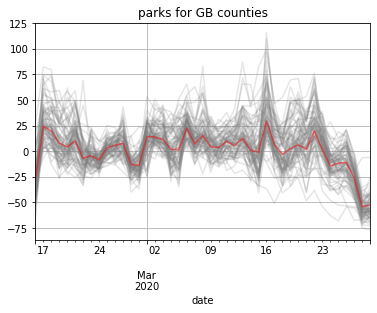

In [233]:
fig, ax = plt.subplots()
state = "GB"
# county = "Overall"
category = "parks"
dfc[(dfc["state"]==state) & (dfc["county"]!="Overall") & (dfc["category"]==category)].set_index("date").groupby("county")["value"].plot(
    ax=ax,color="gray",
    alpha=0.2,
);
dfc[(dfc["state"]==state) & (dfc["county"]=="Overall") & (dfc["category"]==category)].set_index("date").groupby("county")["value"].plot(
    ax=ax,color="red",
    alpha=0.5,
);
ax.set_title(f"{category} for {state} counties")
ax.grid('on')